## Time Series Analysis: Statistical Methods versus Deep Learning

Time series is a set of observations on the values that a variable takes at different times. Time dependency and have some form of seasonal trends makes difference from regular regression so the analysis method is also different for time series.  
The aim of this project is apply some basic techniques for time series forecasting and compare them.

### Import Libraries

In [0]:
import pandas as pd
import numpy as np
import itertools
from pylab import rcParams
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
from datetime import datetime, timedelta, timezone
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from keras import Sequential
from keras.layers import Dense, LSTM
import warnings
warnings.filterwarnings('ignore')

### Loading and Preprocessing Data

You can download data here:  
U.S. Census Bureau, Advance Retail Sales: Furniture and Home Furnishings Stores [RSFHFSN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSFHFSN, January 9, 2020.  
We used from 2010-01-01 to 2019-11-01 values.

In [0]:
df = pd.read_csv('RSFHFSN.csv',index_col='DATE',parse_dates=True)

In [137]:
df.head()

,RSFHFSN
DATE,
2010-01-01,6324
2010-02-01,6468
2010-03-01,7271
2010-04-01,6729
2010-05-01,6932


In [0]:
df.columns=['Sales']

In [139]:
df.head()

,Sales
DATE,
2010-01-01,6324
2010-02-01,6468
2010-03-01,7271
2010-04-01,6729
2010-05-01,6932


In [140]:
df.index.min(), df.index.max()

(Timestamp('2010-01-01 00:00:00'), Timestamp('2019-11-01 00:00:00'))

In [141]:
df.isnull().sum()

Sales    0
dtype: int64

#### Visualize and Check Data

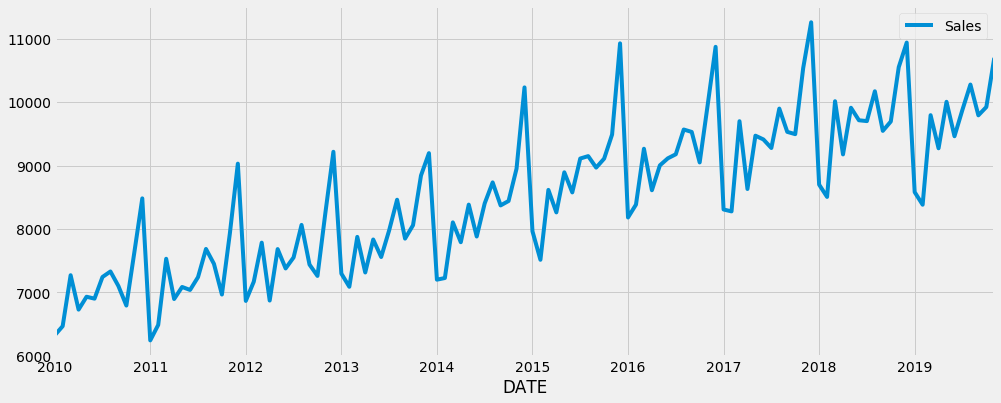

In [142]:
df.plot(figsize=(15, 6))
plt.show()


#### Checking the stationary

Stationary means the mean, variance and covariance is constant over period of time. A lot of statistical forecasting methods assume the data is stationary. We can use Dickey- Fuller test and graphs for checking stationary.  
**Dickey-Fuller Test**'s null hypothesis is that the data is non-stationary. If the p-value is less than the significance level (0.05), we can reject the null hypothesis and say that the series is stationary.  
**Plotting Rolling Statistics**: We can plot the moving average and moving variance and understand if it depends on time.   
We define a function which includes both of above.



In [0]:
def is_stable(ts):

    #Determing rolling statistics
    rolmean = pd.Series(ts).rolling(window=12).mean()
    rolstd = pd.Series(ts).rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey-Fuller test:
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    print (dfoutput)

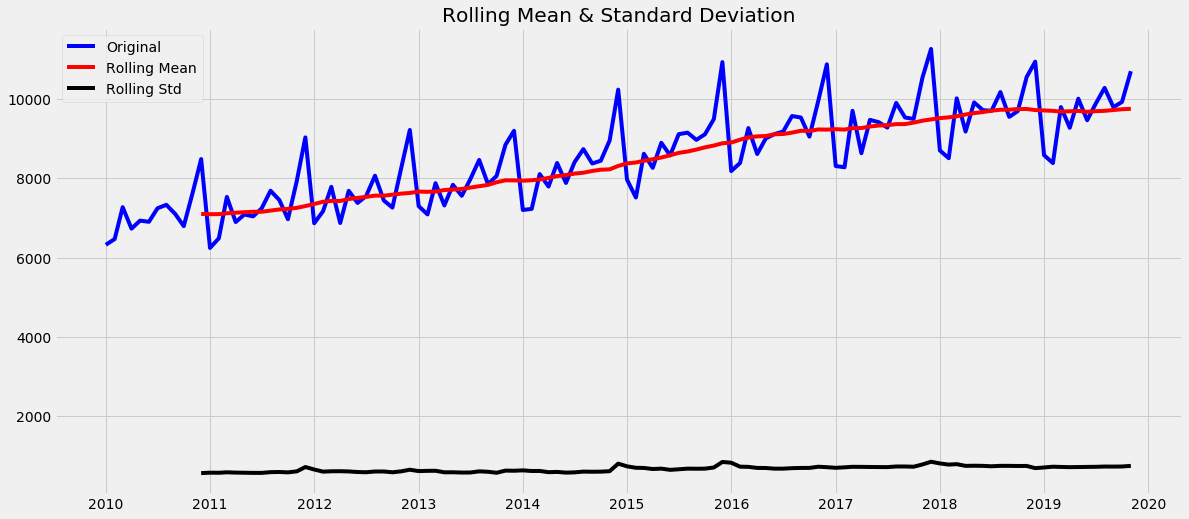

Test Statistic   -1.305563
p-value           0.626624
dtype: float64


In [144]:
rcParams['figure.figsize'] = 18, 8
is_stable(df.Sales)

#### Make Data Stationary

There are 2 main reasons behind non-stationarity of data:  
**Trend**: Changing mean over time.  
**Seasonality**: Variations at specific time intervals.

Lets discuss two ways of removing trend and seasonality:  
**1.Differencing**: Taking the difference with a particular time lag.    
**2.Decomposition**: Modeling both trend and seasonality and removing them from the model.

Before differencing,this process also called "Integration" which denoted "d" generally. "d" is a parameter of some models.

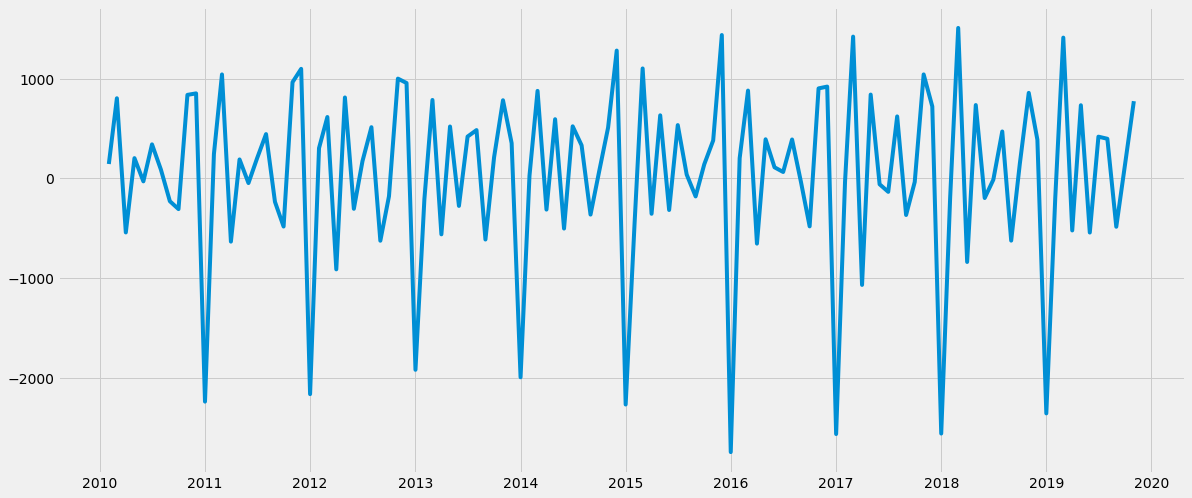

In [145]:
#Differencing
rcParams['figure.figsize'] = 18, 8
df_diff = df - df.shift()
plt.plot(df_diff)
#same thing with another way
#y_diff2=y.diff(periods=1)
#plt.plot(y_diff2)

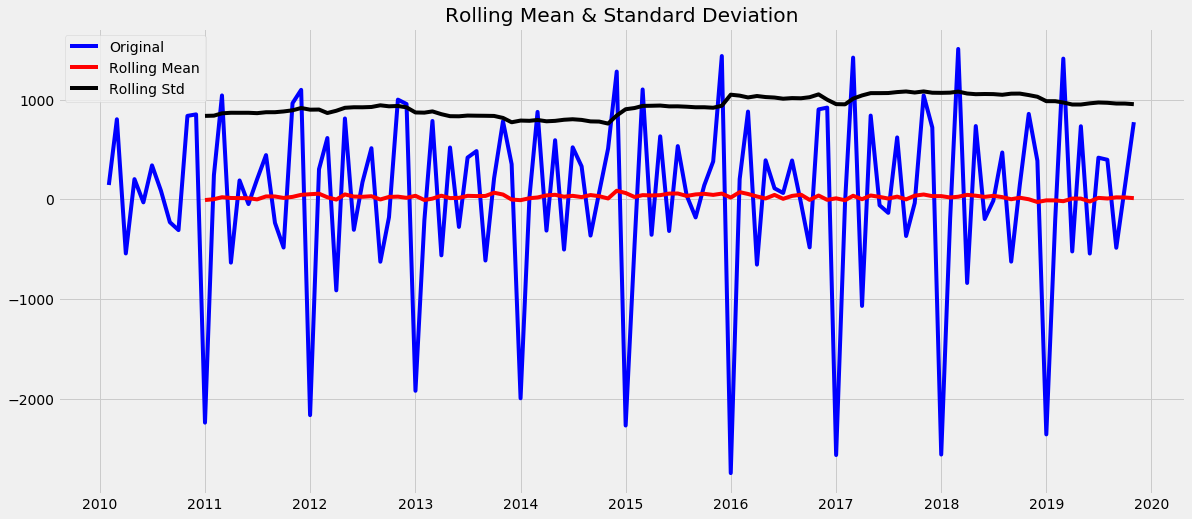

Test Statistic   -3.029406
p-value           0.032238
dtype: float64


In [146]:
#check the result
df_diff.dropna(inplace=True)
is_stable(df_diff.Sales)

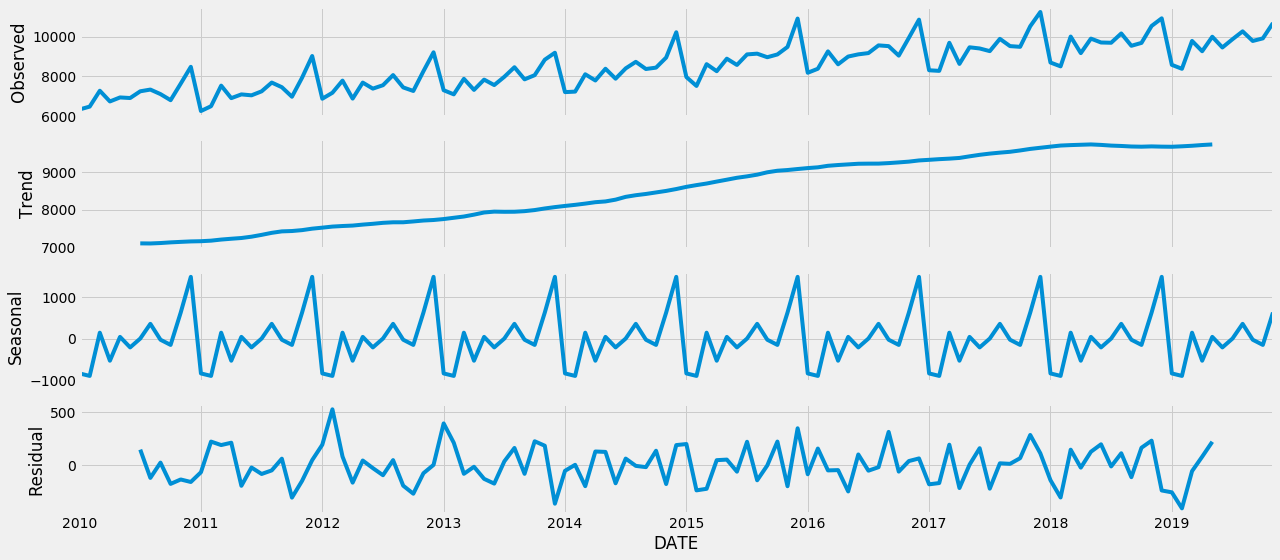

In [147]:
#decompose 
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
decomposition.plot()
plt.show()

Here we can see that the trend, seasonality are separated out from data and we can model the residuals. Lets check stationarity of residuals:

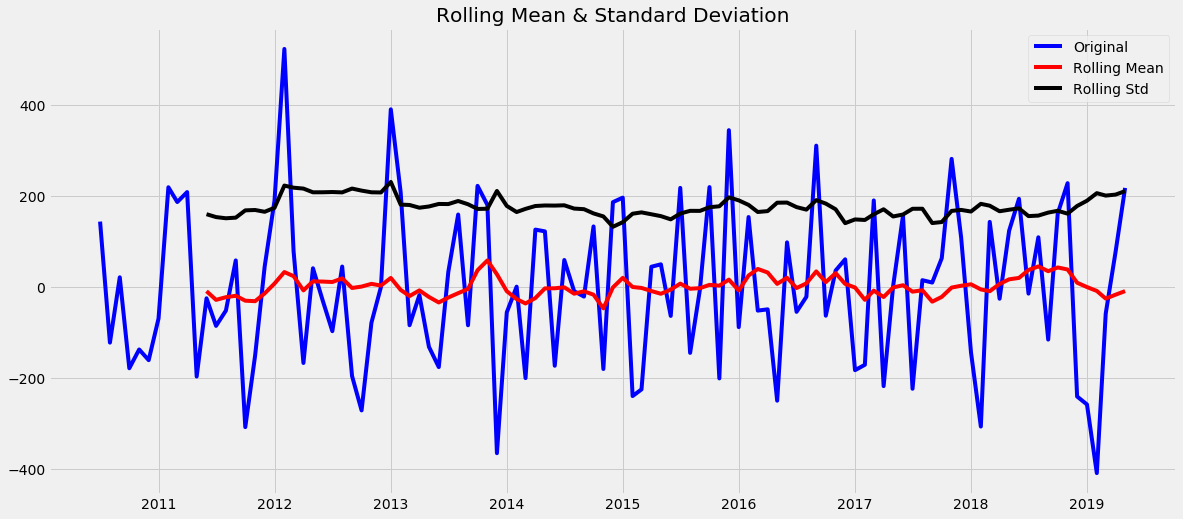

Test Statistic   -6.241178e+00
p-value           4.693171e-08
dtype: float64


In [148]:
#check the decompose results
df_decompose = decomposition.resid
df_decompose.dropna(inplace=True)
is_stable(df_decompose.Sales)

### Descriptions of Methods 

#### AR(AutoRegressive) Model

Yt depends only of past values. Yt is a function of past values. Yt= f( Yt-1, Yt-2, Yt-3...). The model has a p value as a parameter to AR function specifying the order.

#### MA(MovingAverage) Model

Yt depends only on random error terms.Yt is a function of random error terms. Yt= f( εt-1, εt-2, εt-3...). The model has a q value as a parameter to MA function specifying the order.



#### ARIMA(AutoRegressiveIntegratedMovingAverage) Model

 ARIMA combines both AR and MA with Integraion(I). Intagration(I) means a differencing pre-processing step make the data stationary, mentioned above. The model has the parameters as  p to AR ,d to I, q to MA functions specifying the order.


#### SARIMA(SeasonalAutoRegressiveIntegratedMovingAverage) Model

It combines the ARIMA model with the ability to perform same things at the seasonal level. The model has same(p,d,q) for specifying order, extra (P,D,Q)m parameters which refers AR,I,MA at seasonal level and m refers the number of time steps in each season.

### Build Models

An importance job is how to determine the value of ‘p’ and ‘q’. We use two plots to determine these numbers or we find all combinations of them and choose the best according to AIC. Let's discuss them.


#### ACF and PACF Plots

**Autocorrelation Function (ACF)**: It is a measure of the correlation between the data with a lagged version of itself.  
**Partial Autocorrelation Function (PACF)**: This measures the correlation between the data with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons.

In [0]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [0]:
lag_acf = acf(df_diff, nlags=20)
lag_pacf = pacf(df_diff, nlags=20, method='ols')

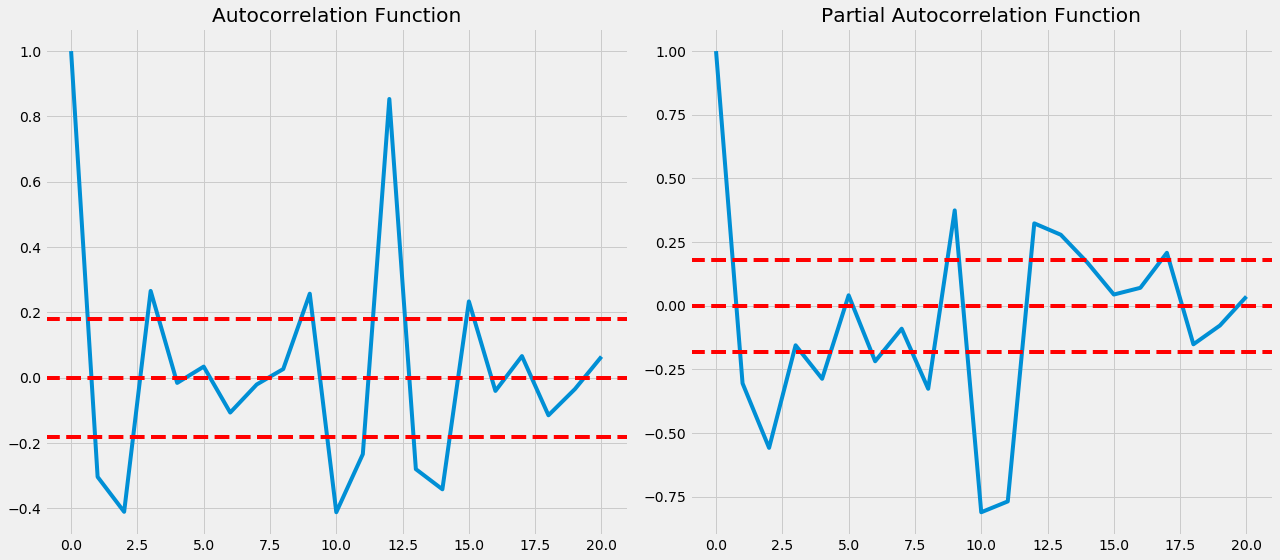

In [151]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='red')
plt.axhline(y=-1.96/np.sqrt(len(df_diff)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(df_diff)),linestyle='--',color='red')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='red')
plt.axhline(y=-1.96/np.sqrt(len(df_diff)),linestyle='--',color='red')
plt.axhline(y=1.96/np.sqrt(len(df_diff)),linestyle='--',color='red')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

The two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the ‘p’ and ‘q’ values as:  
p :The lag value where the PACF chart crosses the upper confidence interval for the first time. In this case p=1.   
q:The lag value where the ACF chart crosses the upper confidence interval for the first time. In this case q=1. 

#### Generating All Different  Parameter Combinations

In [0]:
# Define the p, d and q parameters, between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q
param = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal parameters
seasonal_param = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [153]:
for i in param:
    for j in seasonal_param:
        
            mod = sm.tsa.statespace.SARIMAX(df_diff,
                                            order=i,
                                            seasonal_order=j,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(i,j, results.aic))

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1920.479198703932
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1634.2377254522578
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1489.5978700350972
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1320.6660387088516
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1503.3112895400118
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1485.5870969419527
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1340.2414601745456
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1315.999370296443
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1853.6041037492705
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1577.146406253335
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1433.4959377396804
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1263.0117332382613
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1461.8775712734716
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1426.304752730691
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1297.4781860776243
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1263.5895002916561
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2015.5366333539237
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - A

In this case the best SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1263.0117332382613

In [154]:
from statsmodels.tsa.arima_model import ARIMA
for i in param:
    
            mod = ARIMA(df_diff,order=i)
            results = mod.fit()                               
            print('ARIMA{}-AIC:{}'.format(i,results.aic))                                
                                                        

ARIMA(0, 0, 0)-AIC:1937.6839437841563
ARIMA(0, 0, 1)-AIC:1871.3600112192812
ARIMA(0, 1, 0)-AIC:2034.1011092745296
ARIMA(0, 1, 1)-AIC:1929.063225326648
ARIMA(1, 0, 0)-AIC:1928.3240360391537
ARIMA(1, 0, 1)-AIC:1872.7027105707937
ARIMA(1, 1, 0)-AIC:2008.6318461522033
ARIMA(1, 1, 1)-AIC:1920.319146412782


In this case the best ARIMA(0, 0, 1)-AIC:1871.3600112192812.

In [0]:
data=df_diff


#### AR Model 

In [0]:
# AR example
from statsmodels.tsa.ar_model import AR
# fit model
model = AR(data)
result_ar = model.fit()
# make prediction
model_predicts=[]
yhat_ar = result_ar.predict(len(data), len(data))
#print(yhat_ar)
model_predicts.append(yhat_ar)

#### MA Model

In [0]:
# MA example
from statsmodels.tsa.arima_model import ARMA
# fit model
model = ARMA(data, order=(0, 1))
result_ma = model.fit(disp=False)
# make prediction
yhat_ma = result_ma.predict(len(data), len(data))
#print(yhat_ma)
model_predicts.append(yhat_ma)

#### ARIMA Model

In [0]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
# fit model
model = ARIMA(data, order=(0, 0, 1))
result_arima = model.fit(disp=False)
# make prediction
yhat_arima = result_arima.predict(len(data), len(data)) #, typ='levels'
#print(yhat_arima)
model_predicts.append(yhat_arima)

#### SARIMA Model

In [0]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX
# fit model
model = SARIMAX(data, order=(0, 0, 1), seasonal_order=(0, 1, 1, 12))
result_sarima = model.fit(disp=False)
# make prediction
yhat_sarima = result_sarima.predict(len(data), len(data))
#print(yhat_sarima)
model_predicts.append(yhat_sarima)

#### Plot Results

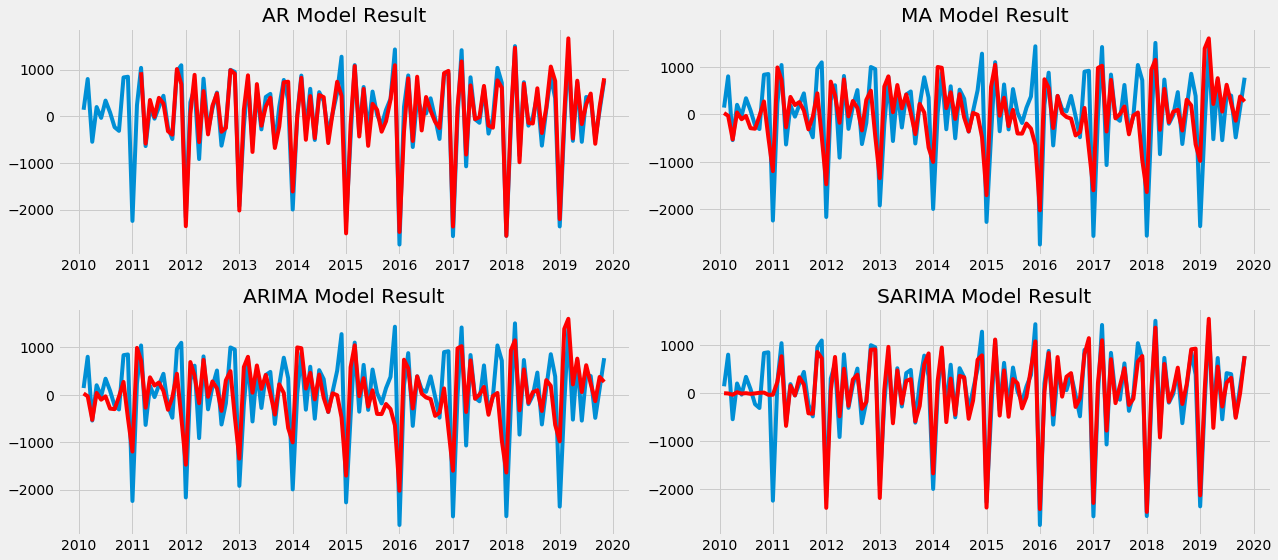

In [248]:
#Plot Results: 
#AR
plt.subplot(221) 
plt.plot(df_diff)
plt.plot(result_ar.fittedvalues, color='red')
plt.title('AR Model Result')
#MA
plt.subplot(222)
plt.plot(df_diff)
plt.plot(result_ma.fittedvalues, color='red')
plt.title('MA Model Result')
#ARIMA
plt.subplot(223) 
plt.plot(df_diff)
plt.plot(result_arima.fittedvalues, color='red')
plt.title('ARIMA Model Result')
#SARIMA
plt.subplot(224) 
plt.plot(df_diff)
plt.plot(result_sarima.fittedvalues, color='red')
plt.title('SARIMA Model Result')
plt.tight_layout()

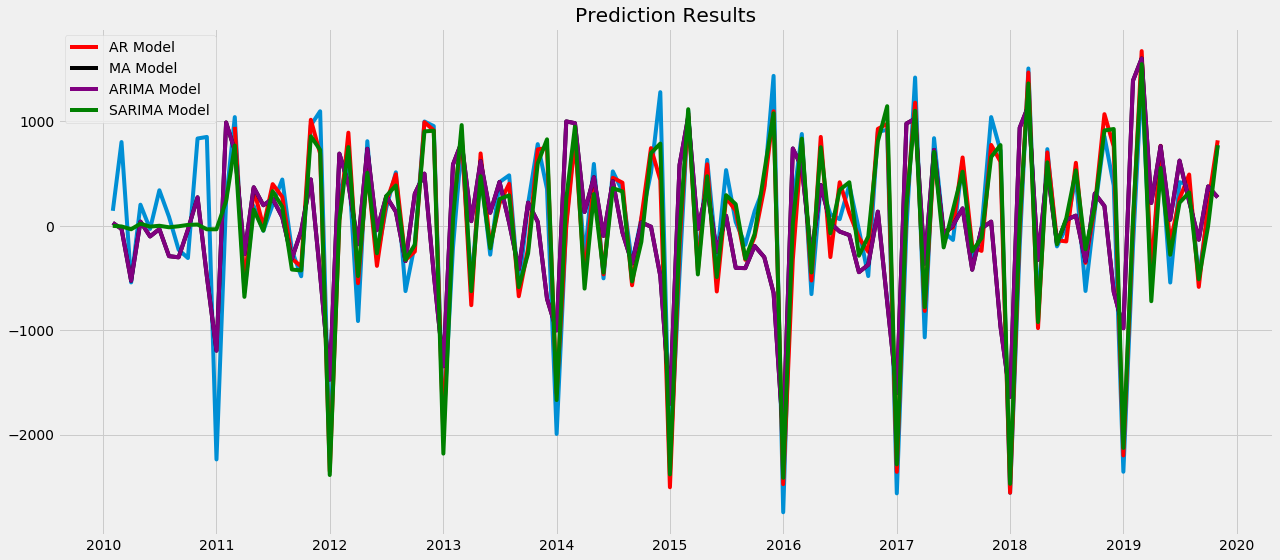

In [249]:
#Plot Results: 
#one graph

plt.plot(df_diff)
plt.plot(result_ar.fittedvalues, color='red', label='AR Model')
plt.plot(result_ma.fittedvalues, color='black', label='MA Model')
plt.plot(result_arima.fittedvalues, color='purple', label='ARIMA Model')
plt.plot(result_sarima.fittedvalues, color='green', label='SARIMA Model')
plt.title('Prediction Results')
plt.legend(loc='best')
plt.tight_layout()

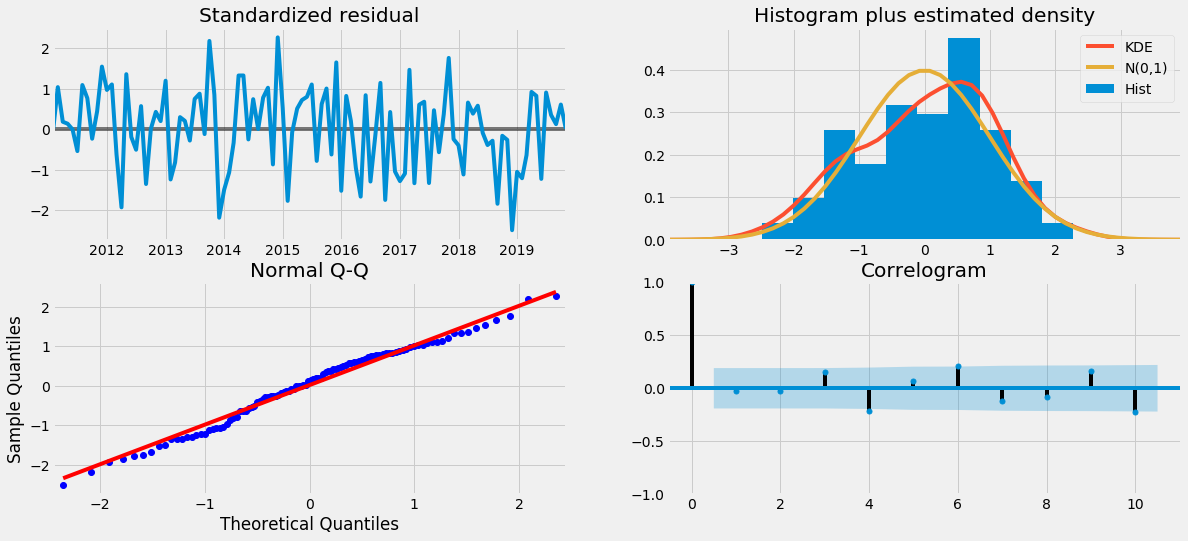

In [226]:
result_sarima.plot_diagnostics()
plt.show()

#### Forecasting

In [0]:
# Get forecast next 18 month
forecasts = result_sarima.get_forecast(steps=18)
#store forecasts
#forecasts_index = pd.date_range(start='2019-12-01',periods=18,freq='MS')
#forecasts_df = pd.DataFrame(data=forecasts.prediction_mean,index=forecasts_index,columns=['Forecasts'])
                           


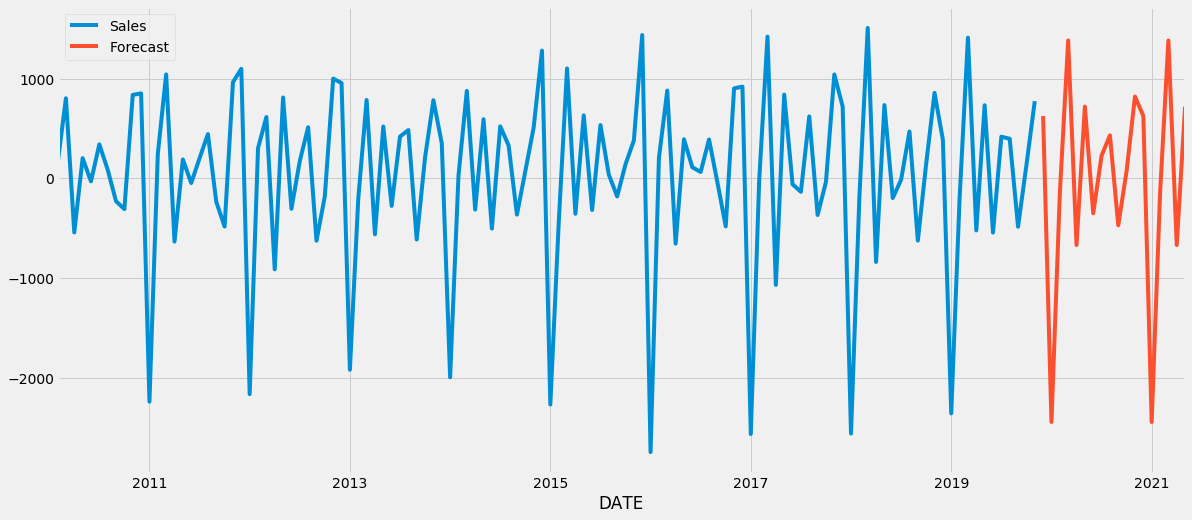

In [272]:
#plot results
ax = df_diff.plot()
forecasts.predicted_mean.plot(ax=ax, label='Forecast')
plt.legend()
plt.show()

### Deep Learning Model

In [0]:
#train-test split
test_size=18
test_ind = len(df)- test_size
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]


In [0]:
#scale data
sc= MinMaxScaler(feature_range=(0,1))
sc.fit(train)
scaled_train = sc.transform(train)
scaled_test = sc.transform(test)

In [0]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [0]:
# 12 months back, predict the next month
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)
# univariate time series
n_features = 1

In [167]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features))) #return_sequences= True,
model.add(LSTM(100, activation='relu')) #,return_sequences= True
model.add(LSTM(units=100))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 12, 100)           40800     
_________________________________________________________________
lstm_6 (LSTM)                (None, 12, 100)           80400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 201,701
Trainable params: 201,701
Non-trainable params: 0
_________________________________________________________________


In [0]:
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [0]:
val_gen = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [171]:
# fit model
model.fit_generator(generator,epochs=100,
                    validation_data=val_gen,
                   callbacks=[early_stop])

Epoch 1/100
89/89 [==============================] - 6s 63ms/step - loss: 0.0487 - val_loss: 0.0080
Epoch 2/100
89/89 [==============================] - 3s 30ms/step - loss: 0.0225 - val_loss: 0.0070
Epoch 3/100
89/89 [==============================] - 3s 30ms/step - loss: 0.0225 - val_loss: 0.0068
Epoch 4/100
89/89 [==============================] - 3s 30ms/step - loss: 0.0221 - val_loss: 0.0067
Epoch 5/100
89/89 [==============================] - 3s 30ms/step - loss: 0.0193 - val_loss: 0.0260
Epoch 6/100
89/89 [==============================] - 3s 30ms/step - loss: 0.0203 - val_loss: 0.0492
Epoch 7/100
89/89 [==============================] - 3s 30ms/step - loss: 0.0166 - val_loss: 0.0121
Epoch 8/100
89/89 [==============================] - 3s 30ms/step - loss: 0.0169 - val_loss: 0.0275
Epoch 9/100
89/89 [==============================] - 3s 30ms/step - loss: 0.0160 - val_loss: 0.0142


In [0]:
#store loss values
loss_df = pd.DataFrame(model.history.history)

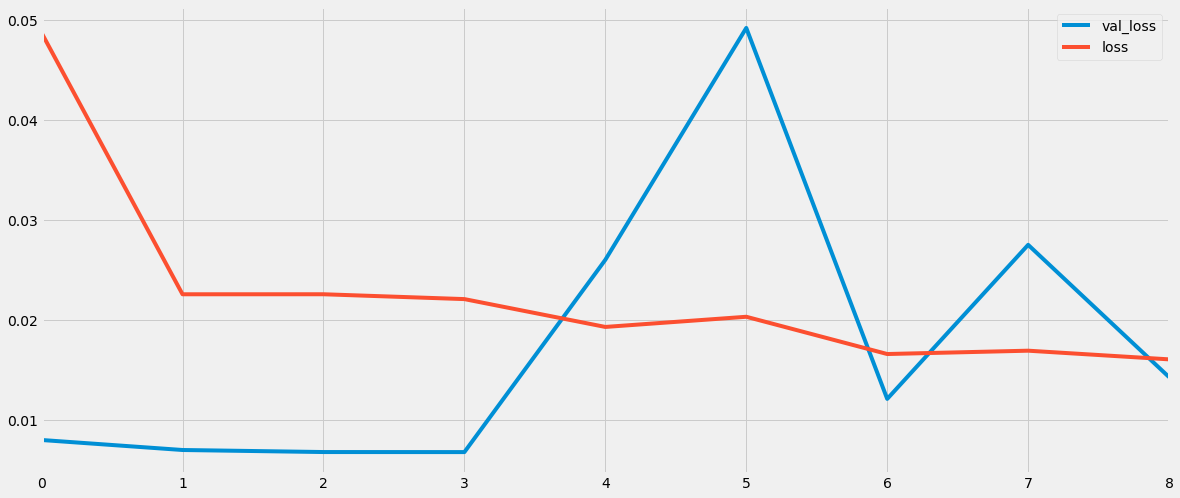

In [173]:
loss_df.plot()

#### Model Evaluation

In [0]:
test_predictions = []

#define and reshape first batch for evaluation
first_batch = scaled_train[-length:]
current_batch = first_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

#### Inverse Predictions

In [0]:
true_predictions = sc.inverse_transform(test_predictions)

In [0]:
test['Predictions'] = true_predictions

In [205]:
test

,Sales,Predictions
DATE,,
2018-06-01,9713,9278.415858
2018-07-01,9700,9162.749028
2018-08-01,10170,9651.378913
2018-09-01,9546,9359.367729
2018-10-01,9693,9350.848398
2018-11-01,10550,10283.885754
2018-12-01,10937,10889.926852
2019-01-01,8581,8789.586076
2019-02-01,8382,8746.597099


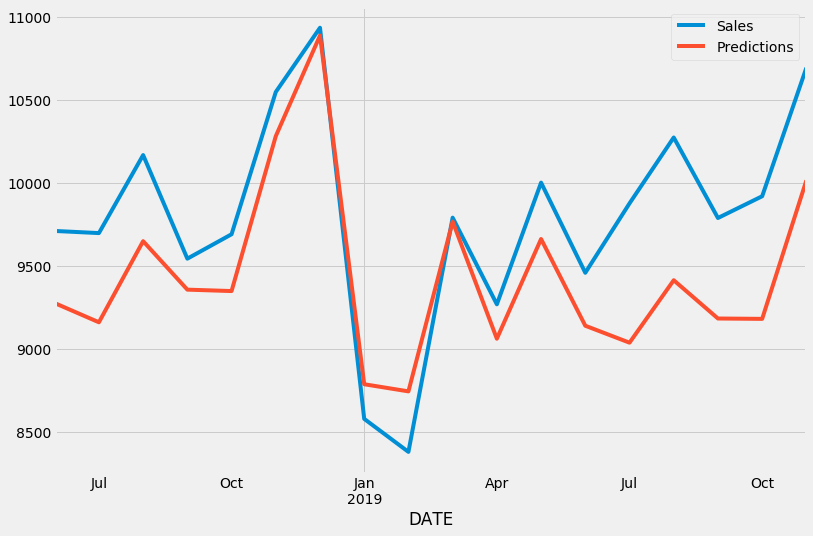

In [206]:
test.plot(figsize=(12,8))

#### Forecasting

In [0]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df)

In [0]:
length = 12 # Length of the output sequences 
generator = TimeseriesGenerator(scaled_df, scaled_df, length=length, batch_size=1)

In [0]:
#define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [211]:
# fit model
model.fit_generator(generator,epochs=20)

Epoch 1/20
107/107 [==============================] - 3s 27ms/step - loss: 0.0660
Epoch 2/20
107/107 [==============================] - 1s 11ms/step - loss: 0.0212
Epoch 3/20
107/107 [==============================] - 1s 12ms/step - loss: 0.0247
Epoch 4/20
107/107 [==============================] - 1s 12ms/step - loss: 0.0209
Epoch 5/20
107/107 [==============================] - 1s 12ms/step - loss: 0.0199
Epoch 6/20
107/107 [==============================] - 1s 12ms/step - loss: 0.0197
Epoch 7/20
107/107 [==============================] - 1s 12ms/step - loss: 0.0199
Epoch 8/20
107/107 [==============================] - 1s 12ms/step - loss: 0.0161
Epoch 9/20
107/107 [==============================] - 1s 12ms/step - loss: 0.0159
Epoch 10/20
107/107 [==============================] - 1s 12ms/step - loss: 0.0139
Epoch 11/20
107/107 [==============================] - 1s 12ms/step - loss: 0.0129
Epoch 12/20
107/107 [==============================] - 1s 12ms/step - loss: 0.0109
Epoch 13/20
1

In [0]:
forecast = []
# forecast period length
periods = 18

first_batch = scaled_df[-length:]
current_batch = first_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead 
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch,include prediction,drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [0]:
forecast = scaler.inverse_transform(forecast)

In [0]:
#df

In [0]:
forecast_index = pd.date_range(start='2019-12-01',periods=periods,freq='MS')

In [0]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [216]:
forecast_df

,Forecast
2019-12-01,10717.094570
2020-01-01,8934.639997
2020-02-01,8866.023407
2020-03-01,9608.237549
2020-04-01,9290.348060
2020-05-01,9807.580990
2020-06-01,9441.099463
2020-07-01,9753.551424
2020-08-01,10096.819030
2020-09-01,9720.886220


#### Plot Results

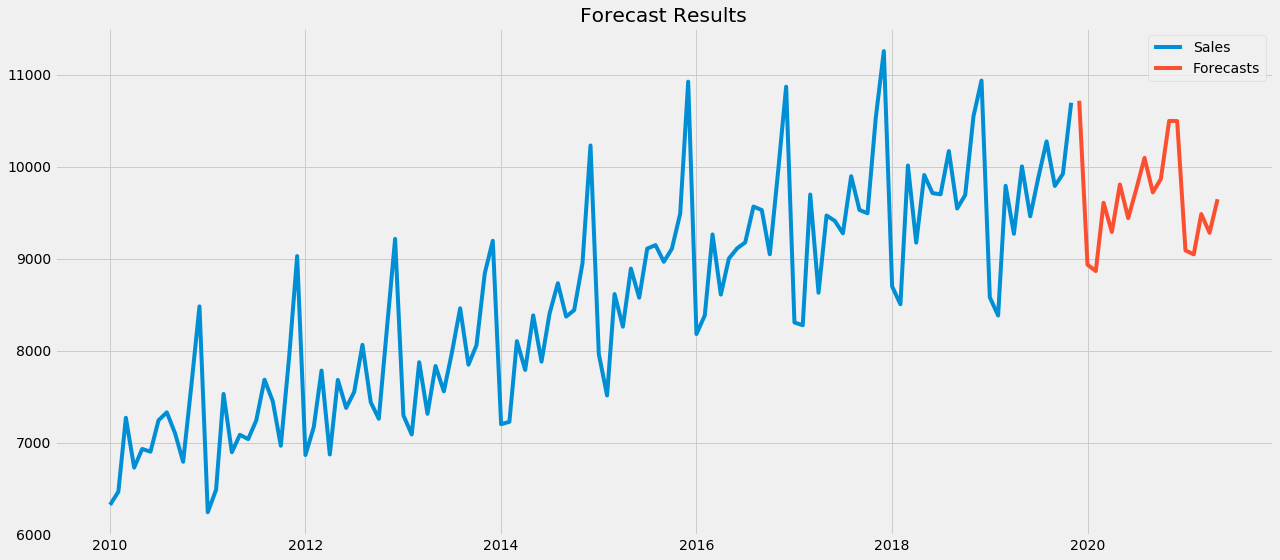

In [250]:
plt.plot(df, label='Sales')
plt.plot(forecast_df, label='Forecasts')
plt.title('Forecast Results')
plt.legend(loc='best')
plt.tight_layout()

### Conclusion

Results of two approaches are not very different. Both of them are succesful. We can't say one is better or not.

In Statistical approach:
* Data preprocessing is very important.There are strict rules for data format.
* Stationary is necessary.
* System is linear.
* Training time is faster.  

In Deep Learning Approach:
* Data preprocessing is faster, you need to just scale data.
* Stationary is not necessary. 
* System includes nonlinear transformations.
* Training time and optimize hyperparameters take more time.  
